In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

In [2]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

database

[*********************100%***********************]  3 of 3 completed


,META,NFLX,TSLA
Date,,,
2002-05-23,NaN,1.196429,NaN
2002-05-24,NaN,1.210000,NaN
2002-05-28,NaN,1.157143,NaN
2002-05-29,NaN,1.103571,NaN
2002-05-30,NaN,1.071429,NaN
...,...,...,...
2022-12-09,115.900002,320.010010,179.050003
2022-12-12,114.709999,315.179993,167.820007
2022-12-13,120.150002,320.339996,160.949997


In [ ]:
# Drop missing values
data = database.dropna().pct_change(1).dropna()

In [6]:
def MV_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
                * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2
    criterion = -criterion
    
    return criterion

In [20]:
# Define train and test sets
split = int(0.7 * len(data))

train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

# Find the number of asset
n = data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result for computations
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.24983658189171304
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2


In [21]:
X_MV

array([0.33376526, 0.33342838, 0.33280637])

In [22]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_MV = np.multiply(test_set,np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)

In [23]:
portfolio_return_MV

Date
2019-10-16    0.005948
2019-10-17    0.012558
2019-10-18   -0.034852
2019-10-21    0.005884
2019-10-22   -0.023943
                ...   
2022-12-09    0.022892
2022-12-12   -0.029333
2022-12-13    0.007663
2022-12-14   -0.007194
2022-12-15   -0.041852
Length: 799, dtype: float64

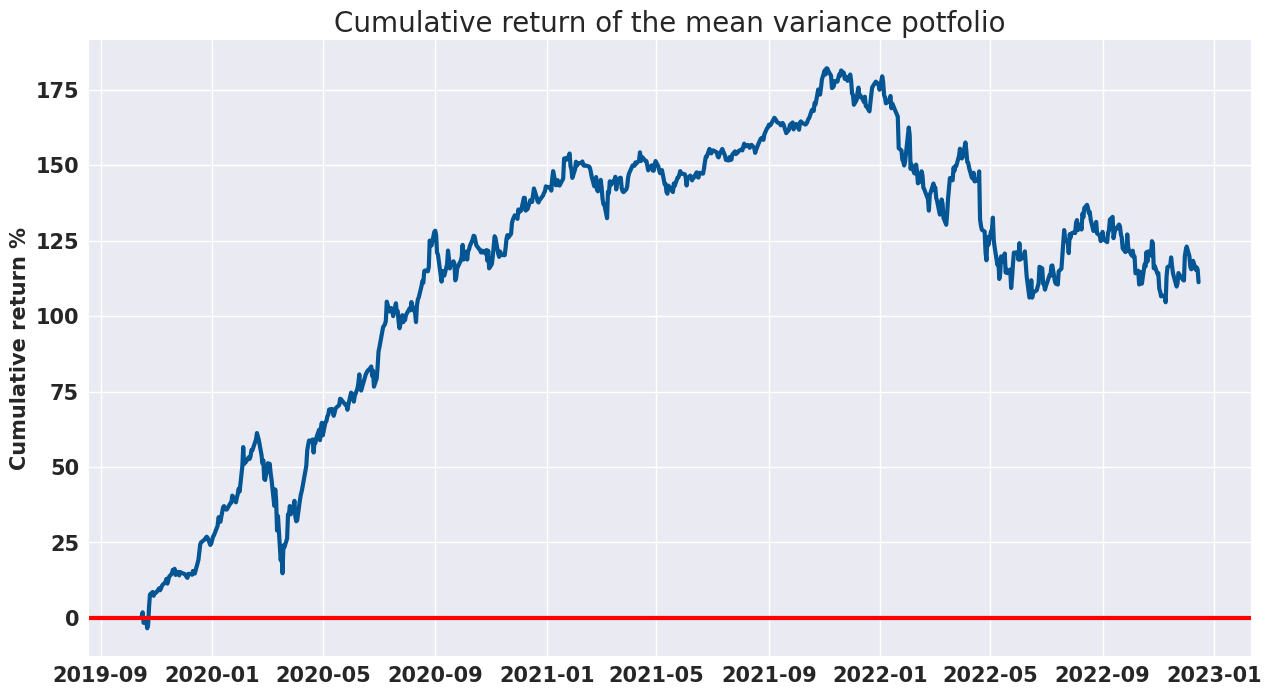

In [24]:
# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.title("Cumulative return of the mean variance potfolio", size=20)
plt.axhline(0, color="r",linewidth=3)
plt.show()